Running on: cuda
--- Starting Training ---
Epoch 1/10 - Avg Energy: 2.6497
Epoch 2/10 - Avg Energy: 0.8173
Epoch 3/10 - Avg Energy: 0.4404
Epoch 4/10 - Avg Energy: 0.3072
Epoch 5/10 - Avg Energy: 0.2520
Epoch 6/10 - Avg Energy: 0.2405
Epoch 7/10 - Avg Energy: 0.2226
Epoch 8/10 - Avg Energy: 0.1721
Epoch 9/10 - Avg Energy: 0.1469
Epoch 10/10 - Avg Energy: 0.1242
--- Training Complete ---


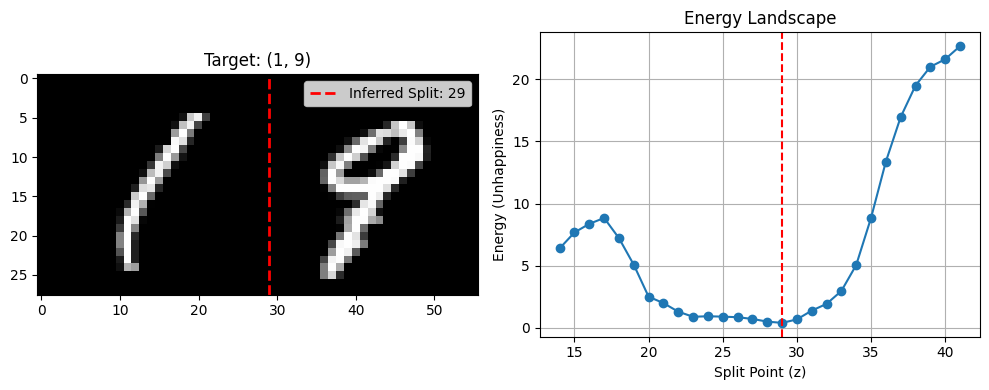

Final Result:
The model believes the best split is at column 29.
If the red line in the graph is at the lowest point (the valley), the EBM works.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP & DATA SIMULATION ---
# We use standard MNIST but "stitch" them together on the fly.

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Load MNIST (Downloads automatically)
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
# We use a batch size of 1 to manually stitch pairs later
loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)
data_iter = iter(loader)

def get_twin_batch(batch_size=1):
    """
    Generates a batch of 'Twin' images.
    Input: Two random MNIST digits.
    Output:
      x: Tensor [batch_size, 1, 28, 56] (The wide image)
      y: List of tuples [(label1, label2), ...]
    """
    global data_iter

    x_list = []
    y_list = []

    for _ in range(batch_size):
        # Grab two distinct images
        try:
            img1, lbl1 = next(data_iter)
            img2, lbl2 = next(data_iter)
        except StopIteration:
            # Restart iterator if we run out
            global loader
            data_iter = iter(loader)
            img1, lbl1 = next(data_iter)
            img2, lbl2 = next(data_iter)

        # Stitch side-by-side
        # img shape is [1, 1, 28, 28]
        twin_img = torch.cat((img1, img2), dim=3) # Concatenate along width

        x_list.append(twin_img)
        y_list.append((lbl1.item(), lbl2.item()))

    # Stack into a batch tensor
    x_batch = torch.cat(x_list, dim=0).to(device)
    return x_batch, y_list

# --- 2. THE JUDGE (MODEL) ---
# A standard CNN. It knows nothing about "Twin" images.
# It only knows how to classify a single 28x28 box.

class SimpleDigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10) # 10 digits

    def forward(self, x):
        # Input: [Batch, 1, 28, 28] (Standard MNIST size)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x) # Logits

model = SimpleDigitCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- 3. THE ENERGY LOGIC ---

def calc_energy(model, x_img, labels, z_split):
    """
    Calculates Energy (Loss) for a SPECIFIC split point 'z'.
    High Energy = Model is confused/wrong.
    Low Energy = Model is confident/correct.

    x_img: Single image tensor [1, 1, 28, 56]
    labels: Tuple (y1, y2)
    z_split: Integer (pixel column index)
    """
    y1, y2 = labels

    # A. CUT THE IMAGE
    # Left: 0 to z
    # Right: z to 56
    left_crop = x_img[:, :, :, :z_split]
    right_crop = x_img[:, :, :, z_split:]

    # B. RESIZE TO 28x28 (So the CNN can read it)
    # We use bilinear interpolation to squash/stretch the crop to 28x28.
    left_ready = F.interpolate(left_crop, size=(28, 28), mode='bilinear', align_corners=False)
    right_ready = F.interpolate(right_crop, size=(28, 28), mode='bilinear', align_corners=False)

    # C. JUDGE IT
    # Pass both crops through the same CNN
    logits_1 = model(left_ready)
    logits_2 = model(right_ready)

    # D. CALCULATE ENERGY
    # We force it to compare against the TRUE labels.
    # If the crop looks like the label, CrossEntropy is low.
    loss_1 = F.cross_entropy(logits_1, torch.tensor([y1]).to(device))
    loss_2 = F.cross_entropy(logits_2, torch.tensor([y2]).to(device))

    return loss_1 + loss_2

def inference_find_z(model, x_img, labels):
    """
    Step 1 of the Dance: The Squint.
    Scans different 'z' values to find the one the model currently likes best.
    """
    best_z = -1
    min_energy = float('inf')

    # Search range: The middle of the 56-pixel image.
    # We check columns 20 to 36.
    # (In Python loops for clarity. In prod, you'd batch this).
    search_space = range(18, 39)

    for z in search_space:
        # Note: No gradients needed for the search itself!
        energy = calc_energy(model, x_img, labels, z)

        if energy.item() < min_energy:
            min_energy = energy.item()
            best_z = z

    return best_z, min_energy

# --- 4. THE TRAINING LOOP ---

print("--- Starting Training ---")
NUM_EPOCHS = 10
BATCHES_PER_EPOCH = 50
BATCH_SIZE = 16

loss_history = []

model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0

    for batch_i in range(BATCHES_PER_EPOCH):
        # 1. Get Data
        x_batch, y_batch = get_twin_batch(BATCH_SIZE)

        total_batch_energy = 0
        optimizer.zero_grad()

        # We process the batch item-by-item because 'z' is different for every image
        for i in range(BATCH_SIZE):
            x_single = x_batch[i].unsqueeze(0) # [1, 1, 28, 56]
            y_single = y_batch[i]

            # --- STEP 1: INFERENCE (The Squint) ---
            # "Model, use your current brain to find the best cut."
            # We use no_grad because we don't backprop through the search loop.
            with torch.no_grad():
                guessed_z, _ = inference_find_z(model, x_single, y_single)

            # --- STEP 2: LEARNING (The Update) ---
            # "Okay, you chose z. Let's see how good that choice really was."
            # Now we run calc_energy WITH gradients enabled at the specific z.
            energy = calc_energy(model, x_single, y_single, guessed_z)

            # Accumulate gradients
            energy.backward()
            total_batch_energy += energy.item()

        # Update weights
        optimizer.step()
        epoch_loss += total_batch_energy / BATCH_SIZE

    avg_loss = epoch_loss / BATCHES_PER_EPOCH
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Avg Energy: {avg_loss:.4f}")

print("--- Training Complete ---")

# --- 5. VISUALIZATION & PROOF ---
# Let's verify if the model actually learned to split digits.

model.eval()

# Get a test image
test_x, test_y = get_twin_batch(1)
x_single = test_x[0].unsqueeze(0)
y_single = test_y[0]

# Run Inference
final_z, final_e = inference_find_z(model, x_single, y_single)

# Create the Energy Landscape (Scan all z's to plot the curve)
energies = []
z_values = list(range(14, 42))
for z in z_values:
    with torch.no_grad():
        e = calc_energy(model, x_single, y_single, z)
        energies.append(e.item())

# PLOTTING
plt.figure(figsize=(10, 4))

# Plot 1: The Image with the cut
plt.subplot(1, 2, 1)
plt.imshow(x_single.cpu().squeeze(), cmap='gray')
plt.axvline(x=final_z, color='r', linestyle='--', linewidth=2, label=f'Inferred Split: {final_z}')
plt.title(f"Target: {y_single}")
plt.legend()

# Plot 2: The Energy Landscape
plt.subplot(1, 2, 2)
plt.plot(z_values, energies, marker='o')
plt.axvline(x=final_z, color='r', linestyle='--')
plt.xlabel("Split Point (z)")
plt.ylabel("Energy (Unhappiness)")
plt.title("Energy Landscape")
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation
print(f"Final Result:")
print(f"The model believes the best split is at column {final_z}.")
print(f"If the red line in the graph is at the lowest point (the valley), the EBM works.")

This tiny project demonstrates the use of Latent Variable Energy-Based Model to do Handwriting Recognition.

It goes a step further from ordinary classification to deciding where the boundaries of characters(digits) are in a multiple-digit image sample.
The Latent Variable in this problem is taken to be the pixel indicating the cutting position of a two conjoined MNIST image data.

We start by making an informed guess during Inference to determine a 'good enough' Latent Variable (z).
Then we use an untrained judge (a simple CNN) to identify the characters.
Next we calculate the energy between the z and the result.
We use this result to update the weights of the untrained CNN.
We end up achieving the dual goal of picking the best z and training a good classification model.